# Description

TODO

# Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from langchain.cache import SQLiteCache
from langchain.globals import set_llm_cache
from proj import conf
from proj.utils import llm_pairwise

# Settings/paths

In [2]:
# # Input manuscript
# REPO = None

# INPUT_FILE = None
# OUTPUT_FILE = None

# # Model and its parameters
# LLM_JUDGE = None
# TEMPERATURE = None
# MAX_TOKENS = 2000
# SEED_INIT = 0

# # Evaluation parameters
# N_REPS = None

In [3]:
INPUT_DIR = conf.common.LLM_PAIRWISE_DIR
assert INPUT_DIR.exists()
display(INPUT_DIR)

PosixPath('/home/miltondp/projects/others/manubot/manubot-ai-editor-code/base/results/llm_pairwise')

# Load LLM pairwise files

In [4]:
result_files = list(INPUT_DIR.glob("*.pkl"))
display(len(result_files))
display(result_files[:2])

12

[PosixPath('/home/miltondp/projects/others/manubot/manubot-ai-editor-code/base/results/llm_pairwise/ccc-manuscript--gpt-3.5-turbo--reversed--mistral_7b-instruct-fp16.pkl'),
 PosixPath('/home/miltondp/projects/others/manubot/manubot-ai-editor-code/base/results/llm_pairwise/biochatter-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl')]

In [5]:
pd.read_pickle(result_files[0])

,rep_index,paragraph_index,paragraph_section,winner,rationale,winner_score
0,0,0,abstract,tie,Both paragraphs are of similar quality with cl...,0.0
1,0,1,introduction,Paragraph 1,While both paragraphs provide a clear overview...,1.0
2,0,2,introduction,tie,Both paragraphs are of similar quality and do ...,0.0
3,0,3,introduction,tie,Both paragraphs are of similar quality. They b...,0.0
4,0,4,results,tie,Both paragraphs have clear sentence structures...,0.0
...,...,...,...,...,...,...
305,9,26,methods,Paragraph 1,Both paragraphs are well-written and provide a...,1.0
306,9,27,methods,tie,Both paragraphs have a clear sentence structur...,0.0
307,9,28,supplementary material,Paragraph 1,While both paragraphs are well-written and fol...,1.0
308,9,29,supplementary material,Paragraph 1,Both paragraphs are well-written and meet all ...,1.0


In [6]:
result_files[0].name.split("--")

['ccc-manuscript', 'gpt-3.5-turbo', 'reversed', 'mistral_7b-instruct-fp16.pkl']

In [7]:
all_results = []

for f in result_files:
    print(f.name, flush=True)
    df = pd.read_pickle(f)
    
    f_name_parts = f.name.split("--")
    idx = 0
    manuscript_code = f_name_parts[idx]
    manuscript_code = manuscript_code.split("-manuscript")[0]
    idx += 1
    
    manuscript_pr_model = f_name_parts[idx]
    idx += 1

    reversed_paragraphs = False
    if len(f_name_parts) > 3:
        reversed_paragraphs = f_name_parts[idx] == "reversed"
        idx += 1
    
    llm_judge = f_name_parts[idx].split(".pkl")[0]

    df.insert(0, "llm_judge", llm_judge)
    df.insert(0, "paragraphs_reversed", reversed_paragraphs)
    df.insert(0, "pr_model", manuscript_pr_model)
    df.insert(0, "manuscript_code", manuscript_code)

    all_results.append(df)

ccc-manuscript--gpt-3.5-turbo--reversed--mistral_7b-instruct-fp16.pkl
biochatter-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl
biochatter-manuscript--gpt-3.5-turbo--reversed--mistral_7b-instruct-fp16.pkl
biochatter-manuscript--gpt-3.5-turbo--mistral_7b-instruct-fp16.pkl
ccc-manuscript--gpt-3.5-turbo--reversed--openai_gpt-4.pkl
biochatter-manuscript--gpt-3.5-turbo--reversed--openai_gpt-3.5-turbo.pkl
ccc-manuscript--gpt-3.5-turbo--openai_gpt-4.pkl
ccc-manuscript--gpt-3.5-turbo--reversed--openai_gpt-3.5-turbo.pkl
ccc-manuscript--gpt-3.5-turbo--openai_gpt-3.5-turbo.pkl
biochatter-manuscript--gpt-3.5-turbo--reversed--openai_gpt-4-turbo-preview.pkl
biochatter-manuscript--gpt-3.5-turbo--openai_gpt-4-turbo-preview.pkl
ccc-manuscript--gpt-3.5-turbo--mistral_7b-instruct-fp16.pkl


In [8]:
df = pd.concat(all_results, ignore_index=True)

In [9]:
df.shape

(3126, 10)

In [10]:
df.head()

,manuscript_code,pr_model,paragraphs_reversed,llm_judge,rep_index,paragraph_index,paragraph_section,winner,rationale,winner_score
0,ccc,gpt-3.5-turbo,True,mistral_7b-instruct-fp16,0,0,abstract,tie,Both paragraphs are of similar quality with cl...,0.0
1,ccc,gpt-3.5-turbo,True,mistral_7b-instruct-fp16,0,1,introduction,Paragraph 1,While both paragraphs provide a clear overview...,1.0
2,ccc,gpt-3.5-turbo,True,mistral_7b-instruct-fp16,0,2,introduction,tie,Both paragraphs are of similar quality and do ...,0.0
3,ccc,gpt-3.5-turbo,True,mistral_7b-instruct-fp16,0,3,introduction,tie,Both paragraphs are of similar quality. They b...,0.0
4,ccc,gpt-3.5-turbo,True,mistral_7b-instruct-fp16,0,4,results,tie,Both paragraphs have clear sentence structures...,0.0


# Process data for plotting

## Reverse scores for reversed paragraphs

In [11]:
df.loc[df["paragraphs_reversed"], "winner_score"] = -1 * df.loc[df["paragraphs_reversed"], "winner_score"]

## Rename values

In [15]:
df["llm_judge"].unique()

array(['mistral_7b-instruct-fp16', 'openai_gpt-3.5-turbo', 'openai_gpt-4',
       'openai_gpt-4-turbo-preview'], dtype=object)

In [16]:
models_rename = {
    "openai_gpt-4": "GPT-4",
    "openai_gpt-4-turbo-preview": "GPT-4 Turbo",
    "openai_gpt-3.5-turbo": "GPT 3.5 Turbo",
    "mistral_7b-instruct-fp16": "Mistral 7b",
}

In [17]:
df["manuscript_code"].unique()

array(['ccc', 'biochatter'], dtype=object)

In [18]:
df["paragraph_section"].unique()

array(['abstract', 'introduction', 'results', 'discussion', 'methods',
       'supplementary material'], dtype=object)

In [19]:
df = df.replace({
    "manuscript_code": {
        "biochatter": "BioChatter",
        "ccc": "CCC",
    },
    "pr_model": models_rename,
    "llm_judge": models_rename,
    "paragraph_section": {
        "abstract": "Abstract",
        "introduction": "Introduction",
        "results": "Results",
        "methods": "Methods",
        "discussion": "Discussion",
        "supplementary material": "Supplementary\nmaterial",
    }
})

# Plot

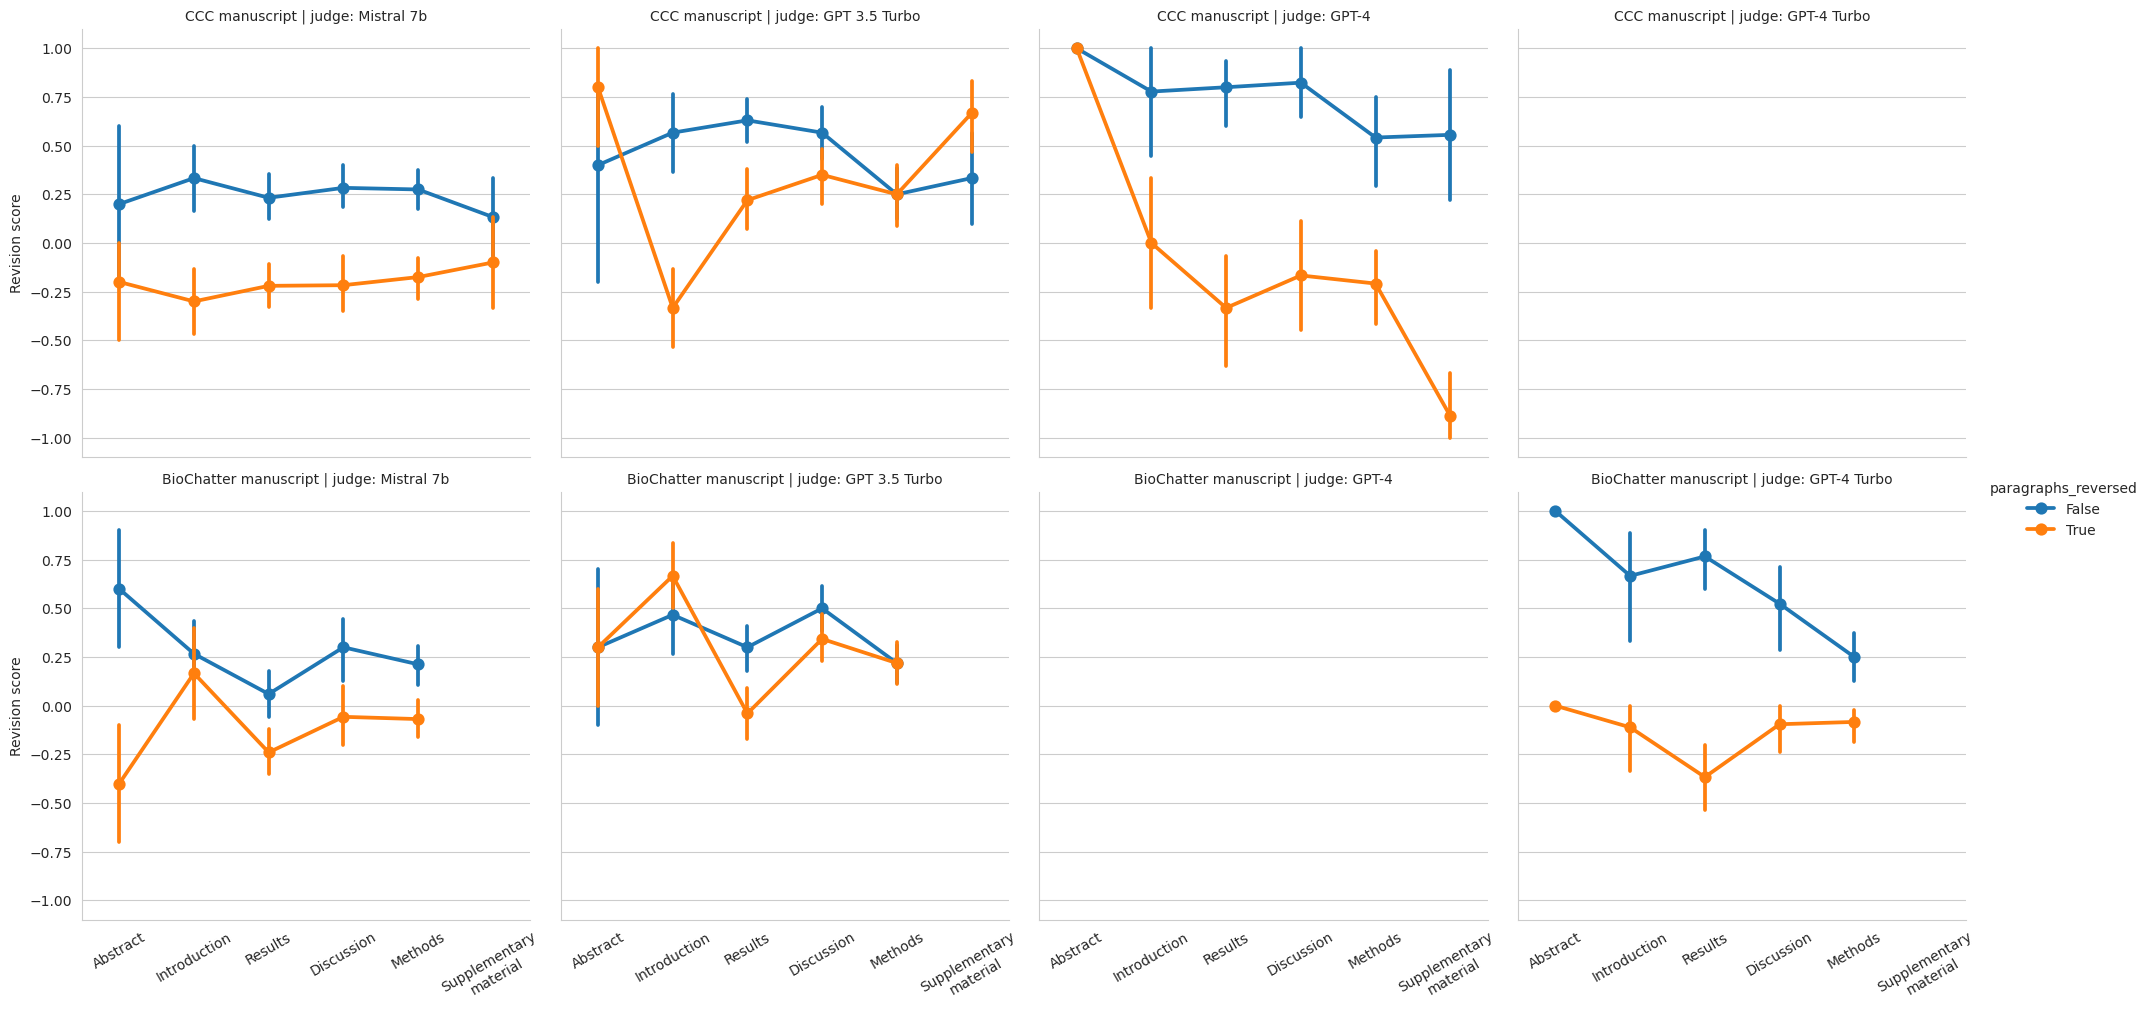

In [20]:
with sns.axes_style("whitegrid"):
    g = sns.catplot(
        data=df,
        x="paragraph_section",
        y="winner_score",
        row="manuscript_code",
        col="llm_judge",
        kind="point",
        hue="paragraphs_reversed",
    )
    g.set_axis_labels("", "Revision score")
    g.set_titles("{row_name} manuscript | judge: {col_name}")
    g.tick_params(axis='x', rotation=30)

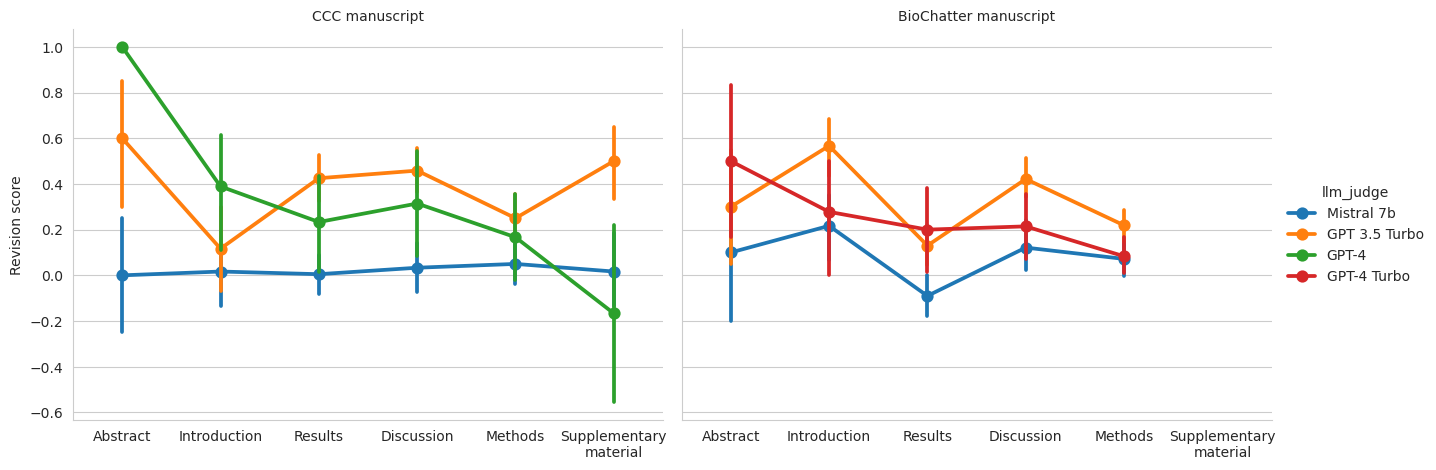

In [21]:
with sns.axes_style("whitegrid"):
    g = sns.catplot(
        height=5,
        aspect=1.3,
        data=df,
        x="paragraph_section",
        y="winner_score",
        col="manuscript_code",
        # col="llm_judge",
        kind="point",
        hue="llm_judge",
    )
    g.set_axis_labels("", "Revision score")
    g.set_titles("{col_name} manuscript")
    # g.tick_params(axis='x', rotation=30)
    # g.set_xticklabels(g.ax.get_xticklabels(), rotation=30)